![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)

# Exploring the Climate Change Service (C3S) Surface Albedo product available through the Climate Data Store (CDS)

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.**

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-land/develop?labpath=exploring-surface-albedo.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-land/blob/develop/exploring-surface-albedo.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-land/blob/develop/exploring-surface-albedo.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-land/blob/develop/exploring-surface-albedo.ipynb)

## Learning objectives 🎯
Surface Albedo, defined as the ratio of the radiant flux reflected from the Earth’s land surface to the incident flux, is considered a terrestrial Essential Climate Variable (ECV) according to the Global Climate Observing System (GCOS) to characterize the state of the global climate system and its evolution resulting from natural and anthropogenic forcing. SA is both a forcing variable controlling the surface energy budget and a sensitive indicator of environmental changes including land degradation (Dickinson, 1995). As a corollary, it also determines the fraction of solar energy absorbed by the surface and transformed into heat or latent energy. Land SA is therefore a key variable for characterizing the energy balance in the coupled surface-atmosphere system and constitutes an indispensable input quantity for soil-vegetation-atmosphere transfer models (Stephens et al., 2015).

The albedo quantity most relevant in terms of energy budget comprises the shortwave domain (SW [0.3 μm, 4 μm]), where the solar downwelling radiation is more relevant (Gueymard et al., 2019). SW domain includes the visible (VI [0.4 μm, 0.7 μm]) and near-infrared (NIR [0.7 μm, 4 μm]). Actually, different definitions of satellite albedo products exist according to the domain of directional integration (Schaepman-Strub et al., 2006): the directional-hemispherical reflectance (DHR) or black-sky albedo (BSA or AL-DH), and the bi-hemispherical reflectance (BHR) or white-sky albedo (WSA or AL-BH). BSA is defined as the ratio of the radiant flux for light reflected by a unit surface area into the view hemisphere to the illumination radiant flux, when the surface is illuminated with a parallel beam of light from a single direction (Lucht and Lewis, 2000). On the other hand, WSA is the ratio of the radiant flux reflected from a unit surface area into the whole hemisphere to the incident radiant flux of hemispherical angular extent (Shuai et al., 2020). Combining BSA and WSA in relation to the proportion of sky irradiance, the blue-sky albedo is obtained, which is the actual albedo value (Lewis & Barnsley, 1994).

In this notebook you will explore the Surface Albedo (SA) product distributed through the Copernicus Climate Change Service (C3S) . You will: 
* Set up a Python environment (a space to work on the data using code) to store and process the data, running some fundamental data checking tasks.
* Search for and retrieve SA data from the Copernicus Climate Data Store (CDS), reading it into your Python environment for use.
* Through three case studies, visualise and examine SA at different spatial scales, before creating a time-series of measurements to look at change over time.

## Prepare your environment

### Set up CDSAPI and your credentials

The first step of the tutorial is to install and import the packages and needed libraries. To download the data, the cdsapi is needed. Note that this package is not commonly included by default on cloud platforms. Please use pip command to install it. Other packages which are not commonly included are netCDF4 and cartopy.

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [ ]:
!pip install -q cdsapi
!pip install -q cartopy
!pip install -q netCDF4
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries

The next step is to import the needed libreries for the tutorial. `cdsapi` to download the data from CDS,`zipfile` to unpack the downloaded data, `NetCDF4` python library to deel with NetCDF format files, and `matplotib` and `cartopy` to plot the maps and time series.

In [2]:
#CDS API
import cdsapi

#Unzip
import zipfile

#NetCDF4
import netCDF4 as nc

#Plotting libraries
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes
import cartopy.crs as ccrs
import matplotlib as mpl

#Os functions to manage folders and files
import os

#Libraries to deal with arrays
import numpy as np

### Specify data directory

In [ ]:
# Directory to store data
# Please ensure that data_dir is a location where you have write permissions
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)

## Explore data

The Copernicus Climate Change Service (C3S) aims to provide key indicators on the drivers of climate change, combining climate observations with the most recent science to develop and deliver quality guaranteed information about the past, current and future climate conditions in Europe and in the world. In response to GCOS, the C3S produces Climate Data Records (CDRs) of many ECVs, including land SA. In the C3S, three broadband quantities are provided (visible, NIR, total shortwave) in both angular integration domains (black-sky and white-sky albedos), as well as spectral albedo for the selected sensor channels. The existing C3S SA CDR, available in the Climate Data Store is based on past and recent Earth Observation satellites time series, retrieved from the National Oceanic and Atmospheric Administration / Advanced Very High Resolution (NOAA/AVHRR) (Apr 1981- Dec 2005, at 4 km), Satellite Pour l’Observation de la Terre / Vegetation (SPOT/VGT) (Dec 1999 - May 2014, at 1 km), Project for On-Board Autonomy Vegetation (PROBA-V) (Dec 2013 – Jun 2020, at 1 km) and currently from Ocean and Land Colour Instrument (OLCI) and Sea and Land Surface Temperature Radiometer (SLSTR) on-board ESA Sentinel-3 satellites (July 2018 – onwards, at 300 m). 

Then, different SA datasets are provided in C3S depending on the sensor input data used or the processing chain applied. 

| Version | Sensor |  Period |
| :---: | :---: | :---: |
|  0.0 | SPOT/VGT <br> PROBA/VGT | 1998-2014 <br> 2014-2020 |
|  1.0 | NOAA/AVHRR <br> SPOT/VGT <br> PROBA/VGT | 1981-2005 <br> 1998-2014 <br> 2014-2020 |
|  2.0 | NOAA/AVHRR <br> SPOT/VGT <br> PROBA/VGT | 1981-2005 <br> 1998-2014 <br> 2014-2020 |
|  3.0* | Sentinel-3/OLCI+SLSTR| July 2018 - April 2019 |

<center>*V3.1 is currently being generated, with updated improved Sentinel-3 input data, from July 2018 to the present.</center><br>



The main characteristics of different versions are summarized below:
* $V0.0$ is a brokered dataset from the Copernicus Global Land Service (CGLS).
* $V1.0$ is produced by the Copernicus Climate Change Service (C3S). In this version uncertainty propagation was performed and the CDR dataset was extended in the past back to 1982 using the AVHRR2/3 NOAA series.
* $V2.0$ is produced by the C3S. This version builds on v1.0 and adds a multi-sensor aspect to the albedo products delivered so far. The inversion of the Bidirectional Reflectance Distribution Function (BRDF) coefficients was improved. A climatological BRDF based on SPOT/VGT is introduced as a priori information used for the inversion of the albedos of each sensor. This aspect increased the quality of the retrieval of the reflectance directional properties from the different sensors and improved the homogeneity among sensors.
* The Sentinel-3 albedo algorithm (Sánchez-Zapero et al., 2023) was developed along with a demonstration dataset ($V3.0$) covering 10 months of data (July 2018-April 2019) to ensure the continuity of C3S CDR (based on NOAA/AVHRR, SPOT/VGT and PROBA-V). This version improves the spatial (300 m) and spectral (nine spectral albedos) of existing datasets. V3 is a pre-operational version that may be replaced by an operational version (V3.1) which is currently under generation. 



Main documentation (algorithm theoretical basis documents, product user guides and product quality assessment reports) can be found in the Climate Data Store catalogue SA documentation.
[C3S Surface albedo 10-daily gridded data documentation](https://cds.climate.copernicus.eu/datasets/satellite-albedo?tab=documentation)


### SA data description
|  Projection | Plate Carrée projection |
| :---: | :--- |
|  Spatial coverage |Almost global, covering  longitudes from 180°E to 180°W and latitudes from 80°N to 60°S.<br> Data corresponding to areas above 80°N or below 60°S are filled with missing values|
|  Spatial resolution |AVHRR: 1/30° (4 km aprox.) <br> VGT: 1/112° (1 km aprox.) <br> Sentinel-3: 1/336° (300 m aprox.)|
|  Temporal coverage |AVHRR: September 1981 to December 2005 <br> SPOT-VGT: April 1998 to May 2014 <br> PROBA-VGT: October 2013 to June 2020 <br> Sentinel-3: July 2018 onwards|
|  Temporal resolution |10 days. SA products are calculated for every 10th, 20th and 30th of the month|


### SA main variables
One multi-layer netCDF file is provided for each main variable. All netCDF have the “*crs*” variable, specifying the coordinate reference system for the data variables. All netCDF files also have the lat and lon dimensional variables, linking latitude and longitude of the geographical location to each pixel in data variables.

| Name | Description |
| :---: | :--- |
|  Broadband directional surface albedo (**ALBB-DH**) | Integration of the Bidirectional Reflectance Distribution Function (BRDF) over the viewing hemisphere. It assumes that all the solar energy is coming in the form of a direct radiation from the sun. Also called black-sky albedo. The integration is computed over visible band [0.4-0.7µm], near infrared band [0.7-4µm] and over total spectrum [0.4-4µm] |
|  Broadband hemispherical surface albedo (**ALBB-BH**) | Integration of the directional albedo over the illumination hemisphere. It assumes a complete diffuse illumination. Also called white-sky albedo. The integration is computed over visible band [0.4-0.7µm], near infrared band [0.7-4µm] and over total spectrum [0.4-4µm]. |
| Spectral directional surface albedo (**ALSP-DH**) | Identical to ALBB-DH but values are given in function of the wavelength. <br> 4 spectral albedos for AVHRR and VGT and 9 spectral albedos for OLCI+SLSTR |
| Spectral hemispherical surface albedo (**ALSP-BH**) | Identical to ALBB-BH but values are given in function of the wavelength. <br> 4 spectral albedos for AVHRR and VGT and 9 spectral albedos for OLCI+SLSTR |

### SA related variables
Along with the main variables the following variables are included: **error** (uncertainty on every band in the variable); **QFLAG** (the quality flag of the product); **NMOD** (the number of valid observations during the synthesis period that are used to calculate the surface albedo); **AGE** (the age of the observation in days).


### SA product layers

#### Information about data layers contained in the Surface Albedo products v0.0, v1.0 and v2.0 
The physical ranges, scaling factor, offset and key characteristics of the different data layers in the AL_DH and AL_BH V0.0 V1.0 and V2.0 products are described in the following table, where XX can be replaced by “DH” and “BH” in the variable column.

| Variable <br> ('xx' for DH or BH) | Unit |  Valid Range | Missing Data Value | Data type | Scaling factor |
| :---: | :--- | :--- | :--- | :--- | :--- |
|  AL_xx_VI | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_VI_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_NI | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_NI_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_BB | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_BB_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_B0 | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_B0_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_B2 | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_B2_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_B3 | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_B3_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_MIR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_MIR_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  QFLAG | unitless | [0,255] | bit7=1 | uint8 | 1 |
|  AGE | days | [0,127] | -1 | int16 | 1 |
|  NMOD | number of valid <br> observations | [0,40] | -1 | int16 | 1 |
|  lat | degrees north | [-60,80] | - | float64 | - |
|  lon | degrees east | [-180,180] | - | float64 | - |
|  time | days since 01/01/1970 | - | - | int64 | - |
|  crs | - | - | - | Text | - |


#### Information about data layers contained in the Surface Albedo products v3.0
The physical ranges, scaling factor, offset and key characteristics of the different data layers in the AL_DH and AL_BH V3.0 products are described in the following table, where XX can be replaced by “DH” and “BH” in the variable column. 

| Variable <br> ('xx' for DH or BH) | Unit |  Valid Range | Missing Data Value | Data type | Scaling factor |
| :---: | :--- | :--- | :--- | :--- | :--- |
|  AL_xx_VI | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_VI_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_NI | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_NI_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_BB | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_BB_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_Oa03 | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_Oa03_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_Oa04 | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_Oa04_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_Oa07 | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_Oa07_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_Oa17 | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_Oa17_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_Oa21 | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_Oa21_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_S1 | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_S1_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_S2 | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_S2_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_S5 | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_S5_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_S6 | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  AL_xx_S6_ERR | unitless | [0,10000] | -32767 | int16 | 0.0001 |
|  QFLAG | unitless | [0,524287] | 4294967295 | uint32 | 1 |
|  lat | degrees north | [-60,80] | - | float64 | - |
|  lon | degrees east | [-180,180] | - | float64 | - |
|  time | days since 01/01/1970 | - | - | float64 | - |
|  crs | - | - | - | Text | - |

### Download the data

After that, the request must be created. In this example, the C3S albedo dataset ALBB-DH on 10th July 2018 for PROBA-V V2 is seleted. 

You can easily modify the request parameters using the [Surface albedo download CDS portal](https://cds.climate.copernicus.eu/datasets/satellite-albedo?tab=download) and see the request in the $API$ $request$ section. 

<center>
    <img src=images/cds_albedo_api_request.png width=1000>
</center>

Use the module retrieve from client to download the data, whose name is indicated in the file variable. 
Please, be patient, the download could take a while.
You can see the status of the download in [Your requests](https://cds.climate.copernicus.eu/requests?tab=all) in the CDS portal.

In [ ]:
# Define the dataset
dataset = "satellite-albedo" 

# Define the request
request = {
    "variable": ["albb_dh"],
    "satellite": ["proba"],
    "sensor": "vgt",
    "product_version": ["v2"],
    "horizontal_resolution": ["1km"],
    "year": ["2018"],
    "month": ["07"],
    "nominal_day": ["10"]
}

# Create a client with the user key
client = cdsapi.Client(url=cdsapi_url,key=cdsapi_key)

# Define the name for the downloaded file 
file='albedo_c3s_pbv_v2_20180710.zip'

# Retrieve the data
client.retrieve(dataset, request, file)

2025-01-30 11:33:57,544 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-01-30 11:33:57,545 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


When the download process is finished, the zip file will be located in the main folder indicated in the `DATADIR` variable. The next step is to unzip de file. The library `zipfile` is used, where the module `extractall` allows to unzip all the compressed files in the `EXTRACTFOLDER` directory.

In [ ]:
# Create a folder to extract the data
EXTRACTFOLDER = DATADIR + 'Unzip_files/'
if not os.path.exists(EXTRACTFOLDER):
    os.mkdir(EXTRACTFOLDER)

# Extract the data   
with zipfile.ZipFile(DATADIR+file, 'r') as zip_ref:
    zip_ref.extractall(EXTRACTFOLDER)
unzip_file = os.listdir(EXTRACTFOLDER)[0]
print(unzip_file)

c3s_ALBB-DH_20180710000000_GLOBE_PROBAV_V2.0.1.nc


### Inspect data

The next step is to read the information located in the NetCDF4 file using print. All the metadata is displayed, as well as the dimensions of the variables, and the variables contained in the file.
After that, an example on how to retrieve metadata, dimensions and variables is shown.

In the example, the time start, sensor and version metadata attributes are read, as well as latitudes and longitudes dimensions and AL_DH_BB band. As an example, the upper left pixel latitude and longitude values are showm.

In [7]:
# Open NetCDF4 file
ncfile = nc.Dataset(EXTRACTFOLDER+unzip_file,'r')

# Display the metadata, dimensions and variables
print(ncfile) 


# Read metadata
print('\n')

time_start = ncfile.time_coverage_start
print('Retrieved time start: '+time_start)
sensor = ncfile.sensor
print('Retrieved sensor: '+sensor)
version = ncfile.product_version
print('Retrieved version: '+version)


# Read dimensions
lats = ncfile['lat'][:]
lons = ncfile['lon'][:]

# Read variables
aldhbb = ncfile['AL_DH_BB'][0,:,:]

# Show the upper left latitude, longitude
print('\n')

print('Upper left latitude :'+str(lats[0]))
print('Upper left longitude :'+str(lons[0]))

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    time_coverage_end: 2018-07-10T23:59:59Z
    time_coverage_start: 2018-06-20T00:00:00Z
    platform: PROBA-V
    sensor: VEGETATION
    Conventions: CF-1.6
    archive_facility: VITO
    copyright: Copernicus Climate Change Service information 2021
    history: Processing line : Idepix v7.0.1 | Atmosphetric correction v2 | Albedo v2.2.401 | pack v1.0.1
    institution: VITO NV
    long_name: Broadband Directional Surface Albedo
    orbit_type: LEO
    parent_identifier: urn:c3s:global:albb-dh_v2_1km
    identifier: urn:c3s:global:albb-dh_v2_1km:c3s_ALBB-DH_20180710000000_GLOBE_PROBAV_V2.0.1
    processing_level: L3
    processing_mode: Reprocessing
    product_version: V2.0.1
    references: https://climate.copernicus.eu/help-and-support
    source: Derived from EO satellite imagery
    title: 10 daily broadband directional surface albedo derived from PROBA-V
    creator_name: Iskander Benhadj
    

## Use case 1: Plot a global map
The use case 1 shows an example of how to plot a global map of the albedo product. In the example, the PROBA-V AL_DH_BB V2 on 10th July 2018 is plotted.
To avoid excessive usage of RAM storage, the AL_DH_BB map is resampled to 1/8 pixels. 

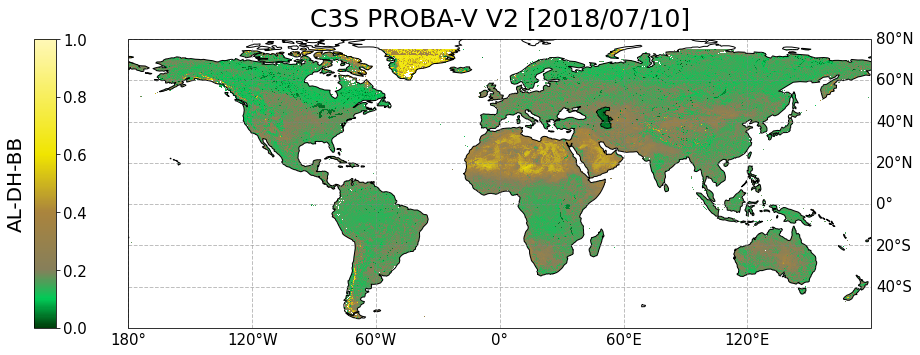

In [ ]:
# Resample AL_DH_BB to 1/8 px
aldhbb_samples = aldhbb[::8,::8]
lats_samples = lats[::8]
lons_samples = lons[::8]

# Create a directory to save the map
MAPDIR = DATADIR + 'Maps_Albedo/'
if not os.path.exists(MAPDIR):
    os.mkdir(MAPDIR)

# Plot

# Create figure
fig = plt.figure(figsize=(15,17))

# Specify the cartopy map projection
projection = ccrs.PlateCarree()
ax = fig.add_subplot(1,1,1, projection=projection)

# Draw coastlines
ax.coastlines(color='black')

# Create colormap
albedocmap = mpl.colors.LinearSegmentedColormap.from_list('albedo_cmap',[(0,'#003e0a'),(0.1,'#02ca57'),(0.2,'#867f5a'),(0.4,'#aa843d'),(0.6,'#f0e500'),(1,'#fff8b7')])

# Plot the map
map1 = ax.pcolormesh(lons_samples, lats_samples, aldhbb_samples, vmin=0, vmax=1,  transform=projection, cmap=albedocmap)

# Create the grid
gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
# Set x- and y-axis labels to True or False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = True
gl.xlabel_style = {'size': 15, 'color': 'black', 'weight': 'normal'}
gl.ylabel_style = {'size': 15, 'color': 'black', 'weight': 'normal'}

# Display the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="3%", pad=1, axes_class=maxes.Axes)
cbar = plt.colorbar(map1,ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('AL-DH-BB', rotation=90, fontsize=20, labelpad=-80)

# Display a title
title='C3S PROBA-V V2 [2018/07/10]'
ax.set_title(title,fontsize=25)

# Specify axis labels size
ax.tick_params(axis="both", labelsize=15)

# Save
fig.savefig(MAPDIR + unzip_file + '.png', dpi=300, bbox_inches='tight')

# Show plot and close
plt.show()
plt.close()


***Figure 1.*** Global map of C3S SA for the selected date and layer.

## Use case 2: Subset, plot and save a local map
The use case 2 shows an example on how to subset a local area, plot the map and save the area in a netCDF4 file. In the example, the PROBA-V AL_DH_BB V2 on 10th July 2018 is used.
An area of approximately 21km x 21km is defined with central coordinate 51.0792N, 10.4522E located over Hainich (Germany) site. In the case of the local map, the native spatial resolution is used.
Firstly, the location of the central coordinates of the site in the global image is calculated. After that, a subset around the central coordinate of size 21km x 21km is done. Then, the subset is saved in netCDF4 format.
Finally, the map is created.

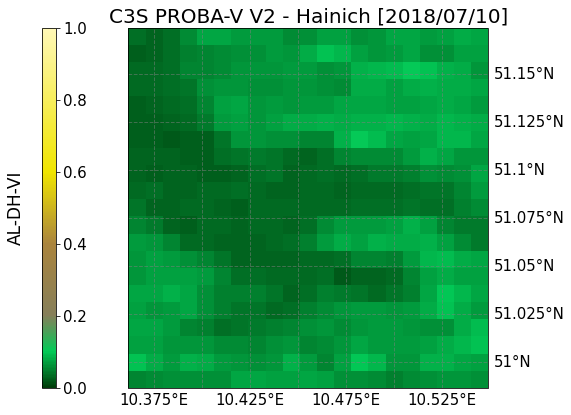

In [ ]:
# Define the center coordinates of the selected region
region_name = 'Hainich'
region_lat = 51.0792
region_lon = 10.4522

# Search the center coordinates of the selected region in the global map
step_deg = lats[0]-lats[1]
corner_lat = lats[0]+1/2*step_deg 
corner_lon = lons[0]-1/2*step_deg
region_y = int((corner_lat-region_lat)/step_deg)
region_x = int((region_lon-corner_lon)/step_deg)

# Create a folder to save the regional netCDF4 file
REGIONALFOLDER = DATADIR + 'Regional_example/'
if not os.path.exists(REGIONALFOLDER):
    os.mkdir(REGIONALFOLDER)

# Make the subset around the center coordinates of the selected region
regional_file = 'c3s_pbv_v2_20180710_Hainich.nc'

# Open the global file as src in read mode and the new empty file as dst in write mode
with nc.Dataset(EXTRACTFOLDER+unzip_file) as src, nc.Dataset(REGIONALFOLDER+regional_file, "w",format='NETCDF4') as dst:
    
    # Copy global attributes all at once via dictionary
    dst.setncatts(src.__dict__)
    
    # Copy dimensions, in case of lat and lon dimensions the new size is 21 pixels
    for name, dimension in src.dimensions.items():
        if name=='time':
            dst.createDimension(
                name, (len(dimension) if not dimension.isunlimited() else None))
        else:
            dst.createDimension(
                name, (21))

    
    # Copy all file data 
    for name, variable in src.variables.items():
        
        if name=='lat':
            x = dst.createVariable(name, variable.datatype, variable.dimensions)
            dst[name][:] = src[name][region_y-10:region_y+11]
            # copy variable attributes all at once via dictionary
            dst[name].setncatts(src[name].__dict__)
            
            
        elif name=='lon':
            x = dst.createVariable(name, variable.datatype, variable.dimensions)
            dst[name][:] = src[name][region_x-10:region_x+11]
            # copy variable attributes all at once via dictionary
            dst[name].setncatts(src[name].__dict__)
        
        elif name=='time' or name=='crs':
            x = dst.createVariable(name, variable.datatype, variable.dimensions)
            dst[name][:] = src[name][:]
            # copy variable attributes all at once via dictionary
            dst[name].setncatts(src[name].__dict__)
        
        else:
            x = dst.createVariable(name, variable.datatype, variable.dimensions)
            dst[name].setncatts(src[name].__dict__)
            dst[name][:] = src[name][:,region_y-10:region_y+11,region_x-10:region_x+11]



# Read the AL_DH_VI band from the recent created regional file
regional_ncfile = nc.Dataset(REGIONALFOLDER+regional_file, "r")
regional_lats = regional_ncfile['lat'][:]
regional_lons = regional_ncfile['lon'][:]
regional_aldhvi = regional_ncfile['AL_DH_VI'][0,:,:]



# Plot

# Create figure
fig = plt.figure(figsize=(8,7))

# Specify the cartopy map projection
projection = ccrs.PlateCarree()
ax = fig.add_subplot(1,1,1, projection=projection)

# Draw coastlines
ax.coastlines(color='black')

# Create colormap
albedocmap = mpl.colors.LinearSegmentedColormap.from_list('albedo_cmap',[(0,'#003e0a'),(0.1,'#02ca57'),(0.2,'#867f5a'),(0.4,'#aa843d'),(0.6,'#f0e500'),(1,'#fff8b7')])

# Plot the map
map1 = ax.pcolormesh(regional_lons, regional_lats, regional_aldhvi, vmin=0, vmax=1,  transform=projection, cmap=albedocmap)

# Create the grid
gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
# Set x- and y-axis labels to True or False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = True
gl.xlabel_style = {'size': 15, 'color': 'black', 'weight': 'normal'}
gl.ylabel_style = {'size': 15, 'color': 'black', 'weight': 'normal'}

# Display the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="4%", pad=1, axes_class=maxes.Axes)
cbar = plt.colorbar(map1,ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('AL-DH-VI', rotation=90, fontsize=17, labelpad=-80)

# Display title
title = 'C3S PROBA-V V2 - Hainich [2018/07/10]'
ax.set_title(title,fontsize=20)

# Specify axis labels size
ax.tick_params(axis="both", labelsize=30)

# Save
fig.savefig(MAPDIR + regional_file + '.png', dpi=300, bbox_inches='tight')

# Show plot and close
plt.show()
plt.close()

    

***Figure 2.*** Local map of C3S SA for the selected region, date and layer.

## Use case 3: Display time series
The use case 3 is an example on how to download, unpack and display time series. In this example, the PROBA-V AL_BH_VI V2 is displayed for six different dates (20th Jan, 20th Feb, 20th Mar, 20th Apr, 20th May and 20th Jun of 2018) to illustrate the transition from snow to snow-free season. The coordinates of the displayed time series are 55.4132N, 122.328E, corresponding to a Needle-leaf forest site.

The first step is to download the data. Please, be patient, the download progress could take a while.

You can see the status of the download in [Your requests](https://cds.climate.copernicus.eu/requests?tab=all) in the CDS portal.

In [ ]:
# Define the dataset
dataset = "satellite-albedo" 

# Define the request
request = {
    "variable": ["albb_bh"],
    "satellite": ["proba"],
    "sensor": "vgt",
    "product_version": ["v2"],
    "horizontal_resolution": ["1km"],
    "year": ["2016"],
    "month": [
        "01", "02", "03",
        "04", "05", "06"
    ],
    "nominal_day": ["20"]
}

# Create a client with the user key
client = cdsapi.Client(url=cdsapi_url,key=cdsapi_key)

# Define the name for the downloaded file 
file='albedo_c3s_pbv_v2_2016.zip'

# Retrieve the data
client.retrieve(dataset, request, file)


2025-01-30 11:34:51,920 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-01-30 11:34:51,921 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


When the download is finished, a zip file will be located in the main folder. After that, the next step is to unpack the files. The unzip files will be saved in the `EXTRACTFOLDER` directory.

In [ ]:
# Create a directory to unpack the data
EXTRACTFOLDER = DATADIR + 'Unzip_files_2016/'
if not os.path.exists(EXTRACTFOLDER):
    os.mkdir(EXTRACTFOLDER)
    
# Unpack the data
with zipfile.ZipFile(DATADIR+file, 'r') as zip_ref:
    zip_ref.extractall(EXTRACTFOLDER)
unzip_files = os.listdir(EXTRACTFOLDER)
print(unzip_files)

['c3s_ALBB-BH_20160120000000_GLOBE_PROBAV_V2.0.1.nc', 'c3s_ALBB-BH_20160220000000_GLOBE_PROBAV_V2.0.1.nc', 'c3s_ALBB-BH_20160320000000_GLOBE_PROBAV_V2.0.1.nc', 'c3s_ALBB-BH_20160420000000_GLOBE_PROBAV_V2.0.1.nc', 'c3s_ALBB-BH_20160520000000_GLOBE_PROBAV_V2.0.1.nc', 'c3s_ALBB-BH_20160620000000_GLOBE_PROBAV_V2.0.1.nc']


After the unpacking process, the coordinates of the site to display in the time series are defined. Then, a folder called `Time_series` is created in the main folder to save the final figure. After that, two arrays are created for both, x and y axis. For each file previously downloaded and unpacked, the AL_BH_VI value is stored in the `aldhvi_values` array while the temporal information is sorted in the `temporal_values` array.

At the end, the temporal serie is created and saved in the directory.

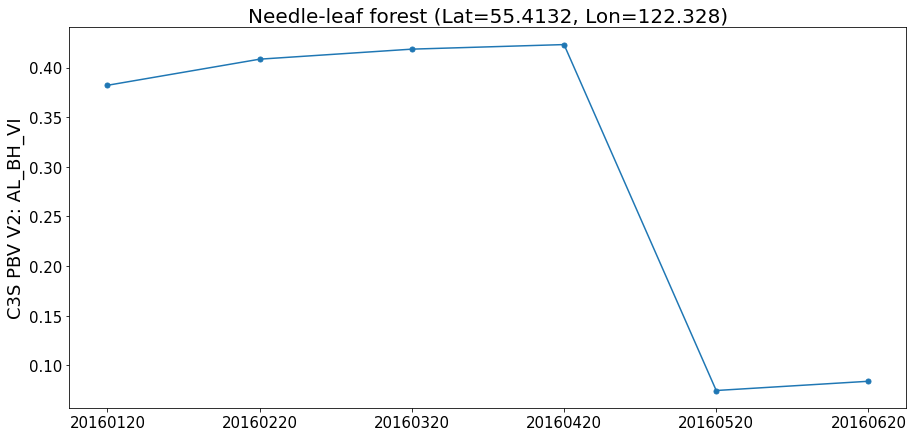

In [ ]:
# Define the coordinates of the site
site_name = 'Needle-leaf forest'
site_lat = 55.4132
site_lon = 122.328


# Create a folder to save the regional netCDF4 file
TIMESERIESFOLDER = DATADIR + 'Time_series/'
if not os.path.exists(TIMESERIESFOLDER):
    os.mkdir(TIMESERIESFOLDER)

# Prepare arrays of the AL-BH-VI values and the temporal information
aldhvi_values=[]
temporal_values=[]
for ff,file in enumerate(os.listdir(EXTRACTFOLDER)): #For each file in the extract folder

    # Read main information
    ncfile = nc.Dataset(EXTRACTFOLDER+file, "r") # Open the netCDF4 file in read mode
    date=file[12:12+8] # Read date from file name convention
    lats=ncfile['lat'][:] #Read latitudes
    lons=ncfile['lon'][:] #Read longitudes

    # Search the center coordinates of the selected region in the global map
    step_deg = lats[0]-lats[1]
    corner_lat = lats[0]+1/2*step_deg 
    corner_lon = lons[0]-1/2*step_deg
    pixel_y = int((corner_lat-site_lat)/step_deg)
    pixel_x = int((site_lon-corner_lon)/step_deg)

    # Read AL_BH_VI value
    aldhvi=ncfile['AL_BH_VI'][0,pixel_y,pixel_x] # Read AL-BH-VI band

    # Save information in arrays
    aldhvi_values.append(aldhvi)
    temporal_values.append(date)


# Make the temporal serie
fig, ax = plt.subplots(nrows=1)
fig.set_size_inches(15, 7)   

# Insert a title
ax.set_title(site_name+' (Lat='+str(site_lat)+', Lon='+str(site_lon)+')',fontsize=20)

# Insert axis y label
ax.set_ylabel('C3S PBV V2: AL_BH_VI', fontsize=18)

# Display the temporal serie
ax.plot(temporal_values,aldhvi_values,marker='o',markersize=5)

# Adjust the size of the ticks in both x and y axis
ax.tick_params(axis='both', labelsize=15)

# Save
fig.savefig(TIMESERIESFOLDER + 'Time_series_C3S_PBV_V2_AL_BH_VI_over_BALMANIP_00250' + '.png', dpi=300, bbox_inches='tight')

# Show plot and close
plt.show()
plt.close()

***Figure 3.*** Time sereis of C3S SA for the selected location, period of time and layer.

## Take home messages 📌

Surface Albedo directly affects Earth's energy balance by determining how much solar radiation is reflected versus absorbed into the Earth's systems, influencing climate systems and feedback loops. Through this notebook you have:
* Explored the data offering of, and retrieved data from, the Copernicus Climate Data Store.
* Identified and retreived a sample of the SA data available through the Copernicus Climate Data Store
* Opened, and examined the data at different spatial scales, and produced a time-series using Python code that can be applied elsewhere, or form the basis of deeper data exploration or analyses.


## References

	
* *Dickinson, R.E., 1995. Land processes in climate models. Remote Sens. Environ. 51, 27–38. [https://doi.org/10.1016/0034-4257(94)00062-R](https://doi.org/10.1016/0034-4257(94)00062-R)*
	
	
* *Gueymard, C.A., Lara-Fanego, V., Sengupta, M., Xie, Y., 2019. Surface albedo and reflectance: Review of definitions, angular and spectral effects, and intercomparison of major data sources in support of advanced solar irradiance modeling over the Americas. Sol. Energy 182, 194–212. [https://doi.org/10.1016/J.SOLENER.2019.02.040](https://doi.org/10.1016/J.SOLENER.2019.02.040)*
	
* *Lewis, P & Barnsley, M., 1994. Influence of the sky radiance distribution on various formulations of the earth surface albedo. Proc. Conf. Phys. Meas. Signatures Remote Sens. 707–715.*

* *Lucht, W., Lewis, P., 2000. Theoretical noise sensitivity of BRDF and albedo retrieval from the EOS-MODIS and MISR sensors with respect to angular sampling. Int. J. Remote Sens. 21, 81–98. [https://doi.org/10.1080/014311600211000](https://doi.org/10.1080/014311600211000)*

* *Sánchez-Zapero, J., Camacho, F., Martínez-Sánchez, E., Gorroño, J., León-Tavares, J., Benhadj, I., Toté, C., Swinnen, E., Muñoz-Sabater, J., 2023. Global estimates of surface albedo from Sentinel-3 OLCI and SLSTR data for Copernicus Climate Change Service: Algorithm and preliminary validation. Remote Sens. Environ. 287, 113460. [https://doi.org/10.1016/J.RSE.2023.113460](https://doi.org/10.1016/J.RSE.2023.113460)*

* *Schaepman-Strub, G., Schaepman, M.E., Painter, T.H., Dangel, S., Martonchik, J. V., 2006. Reflectance quantities in optical remote sensing-definitions and case studies. Remote Sens. Environ. 103, 27–42. [https://doi.org/10.1016/j.rse.2006.03.002](https://doi.org/10.1016/j.rse.2006.03.002)*

* *Shuai, Y., Tuerhanjiang, L., Shao, C., Gao, F., Zhou, Y., Xie, D., Liu, T., Liang, J., Chu, N., 2020. Re-understanding of land surface albedo and related terms in satellite-based retrievals. Big Earth Data 4, 45–67. [https://doi.org/10.1080/20964471.2020.1716561](https://doi.org/10.1080/20964471.2020.1716561)*

* *Stephens, G.L., O’Brien, D., Webster, P.J., Pilewski, P., Kato, S., Li, J.L., 2015. The albedo of Earth. Rev. Geophys. 53, 141–163. [https://doi.org/10.1002/2014RG000449](https://doi.org/10.1002/2014RG000449)*
	
